In [47]:
using Plots, LinearAlgebra, Random
using RandomMatrices, ProgressBars, MatrixEquations
using Convex, SCS, JLD, Gurobi
using MathOptInterface, JuMP
using Mosek, MosekTools
const MOI = MathOptInterface
using KernelEstimator, PGFPlotsX, LaTeXStrings
pgfplotsx()
# const env = Gurobi.Env()

Plots.PGFPlotsXBackend()

In [48]:
using NBInclude
@nbinclude("Data_generation.ipynb")
@nbinclude("Barycenter_algorithms.ipynb")

barycenter_functional (generic function with 1 method)

# Comparing the speed of algorithms (Figure 2)

## Setting parameters (see paper for parameters used for figures)

In [5]:
n = 50
d = 50
α = .03
β = 30
κ = β / α
η₁ = 15
η₂ = 25
η₃ = 40
nIter = 20
nExp = 50

50

## Solution using SDP

In [ ]:
covs = zeros(d,d,n)
sqrt_covs = zeros(d,d,n)

gen1(covs, sqrt_covs, α, β)
SDP(covs)

## GD and EGD

In [6]:
covs = zeros(d,d,n)
sqrt_covs = zeros(d,d,n)

# Set up arrays
times = zeros(5, nExp, nIter)
objective = zeros(5, nExp, nIter)
dist = zeros(4, nExp, nIter)
optimal_objective = zeros(nExp)

for experiment in ProgressBar(1:nExp)
    
    gen1(covs, sqrt_covs, α, β)
    thresh_a = mean(sqrt(minimum(eigvals(covs[:,:,i]))) for i in 1:n)^2
    thresh_b = mean(sqrt(maximum(eigvals(covs[:,:,i]))) for i in 1:n)^2
    
    
    # Compute high precision solution to compare to
    sqrt_best = GD!(2*nIter, covs, sqrt_covs, zeros(2*nIter), zeros(2*nIter), 1, zeros(2*nIter), covs[:,:,1])
    optimal_objective[experiment] = barycenter_functional(sqrt_covs, sqrt_best^2)

    tmp_obj = @view objective[1, experiment, :]
    tmp_times = @view times[1, experiment, :]
    tmp_dist = @view dist[1, experiment, :]
    EGD!(nIter, covs, sqrt_covs, tmp_obj, tmp_times, η₁, thresh_a, thresh_b, tmp_dist, sqrt_best)

    tmp_obj = @view objective[2, experiment, :]
    tmp_times = @view times[2, experiment, :]
    tmp_dist = @view dist[2, experiment, :]
    EGD!(nIter, covs, sqrt_covs, tmp_obj, tmp_times, η₂, thresh_a, thresh_b, tmp_dist, sqrt_best)

    tmp_obj = @view objective[3, experiment, :]
    tmp_times = @view times[3, experiment, :]
    tmp_dist = @view dist[3, experiment, :]
    EGD!(nIter, covs, sqrt_covs, tmp_obj, tmp_times, η₃, thresh_a, thresh_b, tmp_dist, sqrt_best)

    tmp_obj = @view objective[4, experiment, :]
    tmp_times = @view times[4, experiment, :]
    tmp_dist = @view dist[4, experiment, :]
    GD!(nIter, covs, sqrt_covs, tmp_obj, tmp_times, 1, tmp_dist, sqrt_best)
    
    # recenter so that timeseries starts at t=0
    times[1,experiment, :] .= times[1,experiment, :] .- times[1,experiment, 1]
    times[2,experiment, :] .= times[2,experiment, :] .- times[2,experiment, 1]
    times[3,experiment, :] .= times[3,experiment, :] .- times[3,experiment, 1]
    times[4,experiment, :] .= times[4,experiment, :] .- times[4,experiment, 1]
end

0.0%┣                                           ┫ 0/50 [00:00<00:-3, -20.0 it/s]
2.0%┣▉                                          ┫ 1/50 [00:17<Inf:Inf, 0.0 it/s]
4.0%┣█▉                                           ┫ 2/50 [00:20<15:46, 0.1 it/s]
6.0%┣██▊                                          ┫ 3/50 [00:23<08:58, 0.1 it/s]
8.0%┣███▋                                         ┫ 4/50 [00:26<06:40, 0.1 it/s]
10.0%┣████▍                                       ┫ 5/50 [00:29<05:29, 0.1 it/s]
12.0%┣█████▎                                      ┫ 6/50 [00:32<04:45, 0.2 it/s]
14.0%┣██████▏                                     ┫ 7/50 [00:36<04:15, 0.2 it/s]
16.0%┣███████                                     ┫ 8/50 [00:39<03:55, 0.2 it/s]
18.0%┣████████                                    ┫ 9/50 [00:43<03:40, 0.2 it/s]
20.0%┣████████▋                                  ┫ 10/50 [00:46<03:26, 0.2 it/s]
22.0%┣█████████▌                                 ┫ 11/50 [00:50<03:15, 0.2 it/s]
24.0%┣██████████▎           

In [12]:
# Cut off at accuracy 1e-12
log_objective = log10.(max.(dist, 1e-12))

collated = zeros(4, nIter*nExp, 2)
for algo in 1:4
    # Merge results from all experiments
    collated[algo, :, :] = [reshape(times[algo, :, :], (nIter*nExp,)) reshape(log_objective[algo, :, :], (nIter*nExp,))]
    # Sort each algorithm's data by time
    collated[algo, :, :] .= sortslices(collated[algo, :, :], dims=1, lt=(x,y)->isless(x[1],y[1]))
end


smoothed = zeros(4, nIter*nExp)
sm= 100 .* [1 1 1 1]

for algo in 1:4
    # Choose optimal smoothing parameter
    bw = sm[algo] * bwlscv(collated[algo,:,1], gaussiankernel)
    # Kernel regression on data
    smoothed[algo, :] = KernelEstimator.npr(collated[algo, :, 1], collated[algo, :, 2], kernel=gaussiankernel, reg=locallinear, h = bw)
end

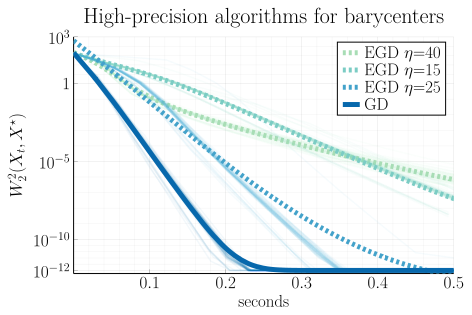

In [13]:
linestyles = [:dash :dash :dash :solid :solid]
linecolors = [4 5 3 6 2]
labels = ["EGD η=$(η₁)" "EGD η=$(η₂)" "EGD η=$(η₃)" "GD" "SDP"]
plt = plot(color_palette=palette(:GnBu_6), 
    title = "High-precision algorithms for barycenters",
    ylabel = L"W_2^2(X_t, X^\star)",
    xlabel = "seconds",
    legend=:topright, 
    minorgrid = true, 
    legendfontsize=17,
    tickfontsize=17,
    labelfontsize=17, 
    titlefontsize=22)
for algo in [3 1 2 4]
    plot!(times[algo, :, :]', log_objective[algo, :, :]', label=nothing, linecolor=linecolors[algo], linewidth=1.5, alpha=.05)
    plot!(collated[algo, :, 1], linestyle = linestyles[algo], smoothed[algo, :], linewidth=5, linecolor=linecolors[algo], label=labels[algo])
end
xlims!(0,.5)
ylims!(-12.2, 3)
yticks!([-12, -10, -5, 0, 3], ["10^{-12}", "10^{-10}", "10^{-5}", "1", "10^3"])
xticks!([.1, .2, .3, .4, .5])
display(plt)

In [15]:
savefig(plt, "./figures/High-precision barycenters")

# Other synthetic data (Figures 7 & 8)

## Setting parameters (see paper for parameters used for figures)

In [16]:
n = 50
d = 50
α = .03
β = 30
κ = β / α
m = Int(floor(d/4))
η₁ = 15
η₂ = 25
η₃ = 40
nIter = 20

20

In [17]:
function experiment(data_generation_method, times, objective, dist, η₁, η₂, η₃)
    covs = zeros(d,d,n)
    sqrt_covs = zeros(d,d,n)
    
    # Generate new dataset
    if data_generation_method==1
        gen1(covs, sqrt_covs, α, β)
    elseif data_generation_method==2
        gen2(covs, sqrt_covs, α, β)
    elseif data_generation_method==3
        gen3(covs, sqrt_covs, κ)
    elseif data_generation_method==4
        gen4(covs, sqrt_covs, α, β)
    elseif data_generation_method==5
        gen5(covs, sqrt_covs, α, β, m)
    elseif data_generation_method==6
        gen6(covs, sqrt_covs, α, β, m)
    elseif data_generation_method==7
        gen7(covs, sqrt_covs, α, β, κ, m)
    else
        pritnln("Error: Loss misspcified")
        return
    end
    thresh_a = mean(sqrt(minimum(eigvals(covs[:,:,i]))) for i in 1:n)^2
    thresh_b = mean(sqrt(maximum(eigvals(covs[:,:,i]))) for i in 1:n)^2


    # Compute high precision solution to compare to
    sqrt_best = GD!(2*nIter, covs, sqrt_covs, zeros(2*nIter), zeros(2*nIter), 1, zeros(2*nIter), covs[:,:,1])
    optimal_objective = barycenter_functional(sqrt_covs, sqrt_best^2)

    tmp_obj = @view objective[1, :]
    tmp_times = @view times[1, :]
    tmp_dist = @view dist[1, :]
    EGD!(nIter, covs, sqrt_covs, tmp_obj, tmp_times, η₁, thresh_a, thresh_b, tmp_dist, sqrt_best)

    tmp_obj = @view objective[2, :]
    tmp_times = @view times[2, :]
    tmp_dist = @view dist[2, :]
    EGD!(nIter, covs, sqrt_covs, tmp_obj, tmp_times, η₂, thresh_a, thresh_b, tmp_dist, sqrt_best)

    tmp_obj = @view objective[3, :]
    tmp_times = @view times[3, :]
    tmp_dist = @view dist[3, :]
    EGD!(nIter, covs, sqrt_covs, tmp_obj, tmp_times, η₃, thresh_a, thresh_b, tmp_dist, sqrt_best)

    tmp_obj = @view objective[4, :]
    tmp_times = @view times[4, :]
    tmp_dist = @view dist[4, :]
    GD!(nIter, covs, sqrt_covs, tmp_obj, tmp_times, 1, tmp_dist, sqrt_best)

    # recenter so that timeseries starts at t=0
    times[1, :] .= times[1, :] .- times[1, 1]
    times[2, :] .= times[2, :] .- times[2, 1]
    times[3, :] .= times[3, :] .- times[3, 1]
    times[4, :] .= times[4, :] .- times[4, 1]
end

experiment (generic function with 1 method)

In [18]:
linecolors = [4 5 3 6 2]
η₁ = 15
η₂ = 25
η₃ = 40
labels = ["EGD η=$(η₁)" "EGD η=$(η₂)" "EGD η=$(η₃)" "GD"]
plts = []
linestyles = [:dot :dot :dot :solid]


for i in 1:7
    
    times = zeros(4, nIter)
    objective = zeros(4, nIter)
    dist = zeros(4, nIter)
    experiment(i, times, objective, dist, η₁, η₂, η₃)
    log_objective = log10.(max.(dist, 1e-12))
    
    tmp = plot(color_palette=palette(:GnBu_6), 
        title = "Input $i",
        ylabel = nothing,
        xlabel = nothing,
        minorgrid = true, 
        legendfontsize=20,
        tickfontsize=17,
        labelfontsize=17, 
        titlefontsize=22)
    for algo in [4 3 1 2]
        plot!(tmp, times[algo, :], log_objective[algo, :], linestyle=linestyles[algo], linecolor=linecolors[algo], linewidth=7, label=labels[algo], legend=nothing)
        yticks!([-12, -5, 0, 3], ["10^{-12}", "10^{-5}", "1", "10^3"])
        xlims!(0,.5)
        xticks!([.2, .4], ["0.2", "0.4"])
    end
    
    push!(plts, tmp)
    if i==7
        tmp = plot(color_palette=palette(:GnBu_6), 
            title = nothing,
            ylabel = nothing,
            xlabel = nothing,
            minorgrid = true, 
            legendfontsize=20,
            tickfontsize=17,
            labelfontsize=17, 
            titlefontsize=22)
        for algo in [4 3 1 2]
            plot!(tmp, times[algo, :], log_objective[algo, :], 
                    foreground_color_axis=:white, linestyle=linestyles[algo], 
                    foreground_color_border=:white, 
                    foreground_color_grid=:white, linecolor=linecolors[algo], linewidth=7, label=labels[algo], alpha=1, grid=false, legend=:topleft)
        end
        ylims!(5,6)
        yticks!([-2,-1])
        xticks!([-10,-2])
        push!(plts, tmp)
    end
end

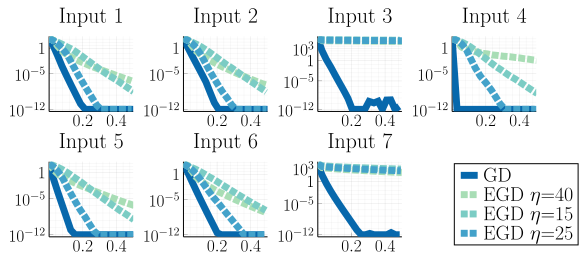

In [19]:
l = @layout [a b c d;e f g h]
plt=plot(plts[1], plts[2], plts[3], plts[4], plts[5], plts[6], plts[7], plts[8], layout=l, size = (750,350))

In [20]:
savefig(plt, "./figures/Barycenter-synthetic")

# Dependence on dimension (Figure 1)

## Setting parameters (see paper for parameters used for figures)

In [54]:
# ds = [50,100,150,200,300,400,500,1000]
ds = [50, 100, 150, 200]
n = 50
# n = 10
α = 0.03
β = 30
κ = β / α
nIter = 30
η = [1/k for k in 1:(nIter*n)];

In [55]:
# Set up arrays
dist = zeros(nIter, length(ds), 2)
vars = zeros(length(ds))
placeholder=zeros(n*nIter)
obj = zeros(length(ds), nIter, 2)

for i in ProgressBar(1:length(ds))
    d = ds[i]
    
    covs = zeros(d,d,n)
    sqrt_covs = zeros(d,d,n)
    
#     gen1(covs, sqrt_covs, α, β)
    generate_known_bary!(covs, sqrt_covs, .1)
    
    sqrt_best = GD!(nIter, covs, sqrt_covs, zeros(nIter), zeros(nIter), 1, zeros(nIter), covs[:,:,1])
    vars[i] = barycenter_functional(sqrt_covs, sqrt_best*sqrt_best)
    
    o = @view obj[i,:,1]
    dist_tmp = @view dist[:,i,1]
    GD!(nIter, covs, sqrt_covs, o, placeholder, 1, dist_tmp, sqrt_best)
    X_SGD = zeros(d, d)
    X_SGD .= covs[:,:,1]
    for j in 1:nIter
        SGD!(covs, sqrt_covs, X_SGD, placeholder, placeholder, η[(j-1)*n+1:j*n])
        dist[j,i,2] = bures(sqrt_best, X_SGD)
        obj[i,j,2] = barycenter_functional(sqrt_covs, X_SGD)
    end
end

0.0%┣                                            ┫ 0/4 [00:00<00:00, -20.0 it/s]
25.0%┣██████████▊                                ┫ 1/4 [00:04<Inf:Inf, 0.0 it/s]
50.0%┣██████████████████████▌                      ┫ 2/4 [00:19<00:39, 0.1 it/s]
75.0%┣█████████████████████████████████▊           ┫ 3/4 [01:02<00:31, 0.0 it/s]
100.0%┣████████████████████████████████████████████┫ 4/4 [02:17<00:00, 0.0 it/s]
100.0%┣████████████████████████████████████████████┫ 4/4 [02:17<00:00, 0.0 it/s]



In [59]:
ϵ = -5
first_index = zeros(length(ds), 2)
v_dist = zeros(size(dist))
for i in 1:length(ds)
    v_dist[:,i,:] .= dist[:,i,:] ./ vars[i]
end

arr = log10.(max.(eps(), v_dist))
for i in 1:2
    for d in 1:length(ds)
        first_index[d, i] = nIter
        done=false
        for j in 1:nIter
            if arr[j,d,i] < ϵ
                done = true
                first_index[d, i] = min(first_index[d,i], j)
            end
        end
        if !done
            first_index[d,i] = NaN
        end
    end
end

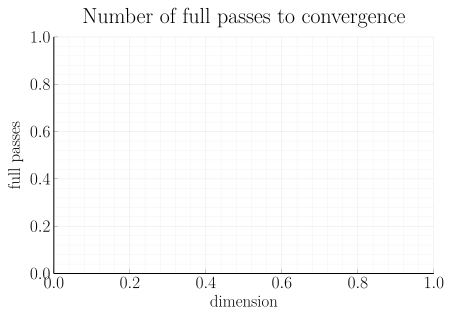

In [57]:
plt = plot(color_palette=palette(:GnBu_6), 
    title = string(L"\textrm{Number of full passes to convergence}"),
    ylabel = "full passes",
    xlabel = "dimension",
    legend=:topleft, 
    minorgrid = true, 
    legendfontsize=17,
    tickfontsize=17,
    labelfontsize=17, 
    titlefontsize=22)

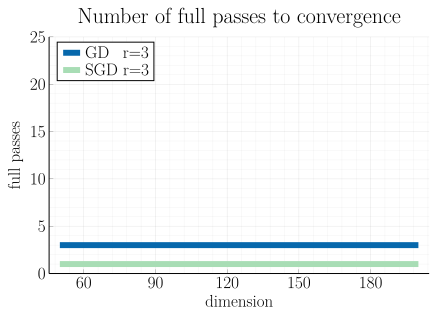

In [58]:
labels = [L"\textrm{GD \,\,\,r=}3", L"\textrm{SGD r=}3"]
linecolors = [6 3]
for i in 1:2
    plot!(plt, ds, first_index[:,i], 
        label=labels[i], 
        linecolor = linecolors[i],
        linewidth = 6)
end
ylims!(0, 25)
display(plt)

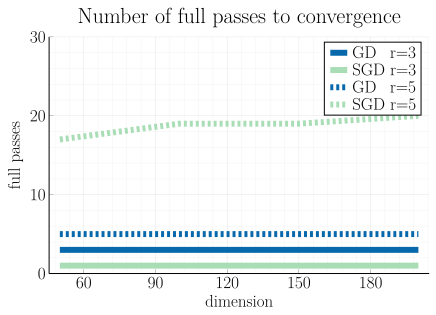

In [60]:
labels = [L"\textrm{GD \,\,\,r=}5", L"\textrm{SGD r=}5"]
linecolors = [6 3]
for i in 1:2
    plot!(plt, ds, first_index[:,i], 
        label=labels[i], 
        linecolor = linecolors[i],
        linewidth = 6, linestyle=:dash, legend=:topright)
end
ylims!(0, 30)
display(plt)

In [61]:
savefig(plt, "./figures/Dimension-dependence")

# ESGD vs SGD (Figure 3) 

## Setting parameters (see paper for parameters used for figures)

In [62]:
n = 2000
d = 300
δ = 0.1
κ = Int(ceil((2 - δ)^2/δ^2))
η = [1/k for k in 1:(2*n)];

In [63]:
covs = zeros(d, d, 2*n)
sqrt_covs = zeros(d, d, 2*n)

generate_known_bary!(covs, sqrt_covs, δ)
thresh_a = mean(sqrt(minimum(eigvals(covs[:,:,i]))) for i in 1:n)^2
thresh_b = mean(sqrt(maximum(eigvals(covs[:,:,i]))) for i in 1:n)^2

objective_SGD = zeros(2*n)
objective_ESGD = zeros(n)
times_SGD = zeros(2*n)
times_ESGD = zeros(n)
SGD!(covs, sqrt_covs, objective_SGD, times_SGD, η)
ESGD!(covs[:,:,1:n], sqrt_covs[:,:,1:n], objective_ESGD, times_ESGD, η, thresh_a, thresh_b)

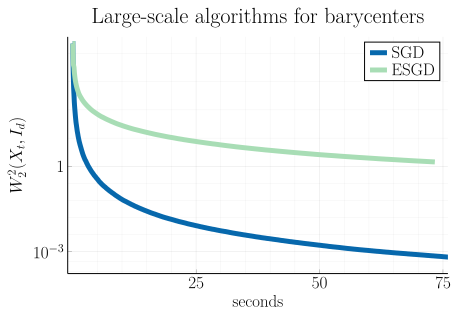

In [64]:
plt = plot(color_palette=palette(:GnBu_6), 
    title = "Large-scale algorithms for barycenters",
    ylabel = L"W_2^2(X_t, I_d)",
    xlabel = "seconds",
    legend=:topright, 
    minorgrid = true, 
    legendfontsize=17,
    tickfontsize=17,
    labelfontsize=17, 
    titlefontsize=22)
labels = ["SGD" "ESGD"]
linecolors = [6 3]
for i in 1:2
    plot!(i==1 ? times_SGD : times_ESGD, log.(i==1 ? objective_SGD : objective_ESGD), 
            linecolor = linecolors[i], 
            linewidth = 5, 
            label=labels[i])
end
xlims!(-01,76)
yticks!([-3, 0, 5], ["10^{-3}", "1", "10^5"])
xticks!([25, 50,75])
display(plt)

In [65]:
savefig(plt, "./figures/Large-scale barycenters")